# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [32]:
# Load pickled data
import pickle
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

#Folder where training data is stored
training_file = 'data/train.p'
validation_file= 'data/valid.p'
testing_file = 'data/test.p'

#Open data files
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
#Set data holders
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 42

Class distribution for training set


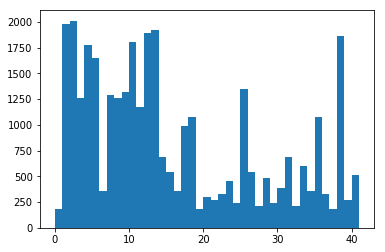

In [80]:
#Number of training examples
n_train = X_train.shape[0]

#Number of validation examples.
n_valid =  X_valid.shape[0]

#Number of testing examples.
n_test =  X_test.shape[0]

#Get image shape
image_shape =  X_train[0].shape

#Number of unique classes/labels in the dataset.
n_classes = np.amax(y_train)

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)
print()
print("Class distribution for training set")

#Histogram of classes distribution for the trainning set
#Visualizations will be shown in the notebook.
%matplotlib inline
bins = [i for i in range(0, n_classes)]
plt.hist(y_train, bins=bins) 
plt.savefig('layers/classes.png', dpi=100)
plt.show()

### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

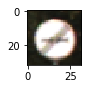

41


In [34]:
#Select a random image from the training set
index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

#Show image
plt.figure(figsize=(1,1))
plt.imshow(image)
plt.savefig('pre/original.png', dpi=300)
plt.show()
print(y_train[index])

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

Example of Pre-processing image
Pre-Processed image


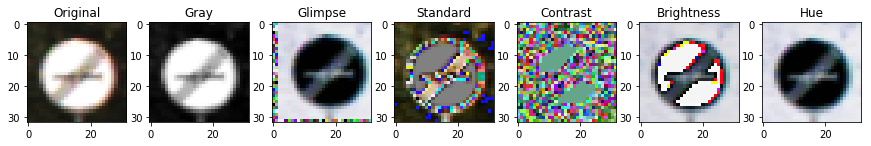

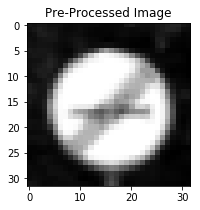

In [35]:
from sklearn.utils import shuffle

#Input and Output Placeholder for Neural Network
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 42) 

#Pre-Processing functions as part of the Pipeline
#x_image = tf.map_fn(lambda img: tf.image.adjust_hue(img, 0.5), x)  
x_image = tf.image.rgb_to_grayscale(x) 
#x_image = tf.image.adjust_contrast(x_image,0.8)
#x_image = tf.image.adjust_brightness(x_image,  0.3)
x_image = tf.map_fn(lambda img: tf.image.per_image_standardization(img), x_image) 

#Function to print pre-processed image
def print_preprocessed_image(image):
    print("Example of Pre-processing image")
    
    plt.figure(figsize=(15,15))
    plt.subplot(7,7,1)
    plt.title("Original")
    plt.imshow(image)
 
    #Pre-processing pipeline    
    x_print = tf.placeholder(tf.float32, (None, 32, 32, 3))   
    x_pre_hue = tf.map_fn(lambda img: tf.image.adjust_hue(img, 1), x_print)              
    x_pre_gray     = tf.image.rgb_to_grayscale(x_print)      
    x_pre_brightness = tf.image.random_brightness(x_print, max_delta=0.3)
    x_pre_contrast = tf.image.random_contrast(x_print, 0.8, 1.2)
    x_pre_standard = tf.map_fn(lambda img: tf.image.per_image_standardization(img), x_print)   
    offset = tf.random_uniform([2], minval=-5, maxval=5, dtype=tf.float32)
    x_pre_glimpse = tf.image.extract_glimpse(x_print, [32,32], [offset], centered=True, normalized=False, uniform_noise=False)
    

    with tf.Session() as sess:

        p_gray = sess.run(x_pre_gray, feed_dict={x_print: [image]})                     
        plt.subplot(7,7,2)
        plt.title("Gray")
        plt.imshow(p_gray[0].squeeze(), cmap='gray')            
        
        p_glimpse = sess.run(x_pre_glimpse, feed_dict={x_print: [image]})    
        plt.subplot(7,7,3)
        plt.title("Glimpse")
        plt.imshow(p_glimpse[0])      
        
        p_standard = sess.run(x_pre_standard, feed_dict={x_print: [image]})         
        plt.subplot(7,7,4)
        plt.title("Standard")
        plt.imshow(p_standard[0]) 
        
        p_contrast = sess.run(x_pre_contrast, feed_dict={x_print: [image]})         
        plt.subplot(7,7,5)
        plt.title("Contrast")
        plt.imshow(p_contrast[0])   
        
        p_brightness = sess.run(x_pre_brightness, feed_dict={x_print: [image]})     
        plt.subplot(7,7,6)
        plt.title("Brightness")
        plt.imshow(p_brightness[0])         
        
        p_hue = sess.run(x_pre_hue, feed_dict={x_print: [image]})         
        plt.subplot(7,7,7)
        plt.title("Hue")
        plt.imshow(p_hue[0])         
        
        plt.savefig('pre/augment.png', dpi=100)
        
        print("Pre-Processed image")
        
        p_pre = sess.run(x_image, feed_dict={x: [image]})         
        
        plt.figure(figsize=(3,3))
        plt.title("Pre-Processed Image")   
        plt.imshow(p_pre[0].squeeze(), cmap='gray')                 
        plt.savefig('pre/pre-processed.png', dpi=100) 
        
            
print_preprocessed_image(image)

In [36]:
#Data Augmentation

#This tensor pipeline is to be used before the main neural network pipeline.
#Change Contrast, Brightness and move (translation) the image randomly

#The image may move up to 10 pixels up/down and/or righ/left
offset = tf.random_uniform([256,2], minval=-7, maxval=7)

#Here, the batch size is fixed because of a bug with the extract_glimpse function
x_augment = tf.placeholder(tf.float32, (256, 32, 32, 3))
x_augment_final = tf.image.random_contrast(x_augment, 0.8, 1.2)
x_augment_final = tf.image.random_brightness(x_augment , max_delta=0.3) #2
x_augment_final = tf.image.extract_glimpse(x_augment_final, [32,32], offset, centered=True, normalized=False, uniform_noise=True)    


def print_augment_image():
    print("Augmented image")

    with tf.Session() as sess:

        p_aug = sess.run(x_augment_final, feed_dict={x_augment: [image]})                 
        plt.figure(figsize=(3,3))
        plt.title("Augmented Image")   
        plt.imshow(p_aug[0].squeeze(), cmap='gray')                 
        plt.savefig('pre/pre-augmented.png', dpi=100)

#print_augment_image()


### Model Architecture

In [37]:
from tensorflow.contrib.layers import flatten

# Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
mu = 0
sigma = 0.1 
keep_prob = tf.placeholder(tf.float32)
    
#Layer 1: Convolutional. Input = 32x32x1. Output = 32x32x6.    
layer1_w = tf.Variable(tf.truncated_normal([5, 5, 1, 6], mu, sigma))
layer1_b = tf.Variable(tf.zeros([6]))
layer1 = tf.nn.conv2d(x_image, layer1_w, strides=[1, 1, 1, 1], padding='SAME', name = 'conv1')
layer1 = tf.nn.bias_add(layer1, layer1_b)        
#Relu Activation.
layer1 =  tf.nn.relu(layer1, name='relu1')  
    
#Layer 2: Convolutional. Input = 32x32x6. Output = 28x28x16.    
layer2_w = tf.Variable(tf.truncated_normal([5, 5, 6, 16], mu, sigma)) 
layer2_b = tf.Variable(tf.zeros([16])) 
layer2 = tf.nn.conv2d(layer1, layer2_w, strides=[1, 1, 1, 1], padding='VALID', name = 'conv2')
layer2 = tf.nn.bias_add(layer2, layer2_b)        
#Relu Activation.
layer2 =  tf.nn.relu(layer2, name='relu2')

#Pooling 1: Input = 28x28x16. Output = 14x14x16.
pool1 = tf.nn.max_pool(layer2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name = 'pool1')
    
#Layer 3: Convolutional. Input = 14x14x16. Output = 12x12x32.
layer3_w = tf.Variable(tf.truncated_normal([3, 3, 16, 32], mu, sigma)) 
layer3_b = tf.Variable(tf.zeros([32])) 
layer3 = tf.nn.conv2d(pool1, layer3_w, strides=[1, 1, 1, 1], padding='VALID', name = 'conv3')
layer3 = tf.nn.bias_add(layer3, layer3_b)       
#Activation.
layer3 =  tf.nn.relu(layer3, name='relu3')
    
#Layer 4: Convolutional. Input = 12x12x32. Output = 14x14x64.
layer4_w = tf.Variable(tf.truncated_normal([3, 3, 32, 64], mu, sigma)) 
layer4_b = tf.Variable(tf.zeros([64])) 
layer4 = tf.nn.conv2d(layer3, layer4_w, strides=[1, 1, 1, 1], padding='VALID', name = 'conv4')
layer4 = tf.nn.bias_add(layer4, layer4_b)    
#Activation.
layer4 =  tf.nn.relu(layer4, name='relu4')

#Pooling 2: Input = 10x10x64. Output = 5x5x64.
pool2 = tf.nn.max_pool(layer4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name = 'pool2') 

#Flatten. Input = 5x5x64. Output = 1600.
fc1 = flatten(pool2)
    
#Dropout for generalization
drop_out1 = tf.nn.dropout(fc1, keep_prob)
    
#Layer 5: Fully Connected. Input = 1600. Output = 400.
layer5_w = tf.Variable(tf.truncated_normal([1600, 400], mu, sigma)) 
layer5_b = tf.Variable(tf.zeros([400]))     
layer5 = tf.add(tf.matmul(drop_out1, layer5_w), layer5_b)    
#Activation.
layer5 = tf.nn.relu(layer5)

#Dropout for generalization
drop_out2 = tf.nn.dropout(layer5, keep_prob)
    
#Layer 6: Fully Connected. Input = 400. Output = 120.
layer6_w = tf.Variable(tf.truncated_normal([400, 120], mu, sigma)) 
layer6_b = tf.Variable(tf.zeros([120]))     
layer6 = tf.add(tf.matmul(drop_out2, layer6_w), layer6_b)    
#Activation.
layer6 = tf.nn.relu(layer6)

#Layer 7: Fully Connected. Input = 120. Output = 84.
layer7_w = tf.Variable(tf.truncated_normal([120, 84], mu, sigma)) 
layer7_b = tf.Variable(tf.zeros([84]))     
layer7 = tf.add(tf.matmul(layer6, layer7_w), layer7_b)    
#Activation.
layer7 = tf.nn.relu(layer7)

#Logits: Fully Connected. Input = 84. Output = 42.
logits_w = tf.Variable(tf.truncated_normal([84, 42], mu, sigma)) 
logits_b = tf.Variable(tf.zeros([42]))     
logits = tf.add(tf.matmul(layer7, logits_w), logits_b)    

#Show network topology
print("Network Architecture")
print("Layer 1: Convolutional")
print(layer1.get_shape())
print("Layer 2: Convolutional")
print(layer2.get_shape())
print("Pooling")
print(pool1.get_shape())
print("Layer 3: Convolutional")
print(layer3.get_shape())
print("Layer 4: Convolutional")
print(layer4.get_shape())
print("Pooling")
print(pool2.get_shape())
print("Layer 5: Fully connected")
print(layer5.get_shape())
print("Layer 6: Fully connected")
print(layer6.get_shape())
print("Layer 7: Fully connected")
print(layer7.get_shape())
print("Layer 8: Logits")
print(logits.get_shape())

    


Network Architecture
Layer 1: Convolutional
(?, 32, 32, 6)
Layer 2: Convolutional
(?, 28, 28, 16)
Pooling
(?, 14, 14, 16)
Layer 3: Convolutional
(?, 12, 12, 32)
Layer 4: Convolutional
(?, 10, 10, 64)
Pooling
(?, 5, 5, 64)
Layer 5: Fully connected
(?, 400)
Layer 6: Fully connected
(?, 120)
Layer 7: Fully connected
(?, 84)
Layer 8: Logits
(?, 42)


### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [38]:
EPOCHS = 20
#Setup for augmenting data
augment_data = True
#Augment Data start after epoch 10
augment_data_epoch = 10

#Batch Size
BATCH_SIZE = 256

#Adjustable learning rate to improve convergence
learning_rate = tf.placeholder(tf.float32, shape=[])
#Initial learning rate
rate = 0.001
#Learning Rate decay
delta_rate = 5


#Loss and Optmizer definition
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate) 
training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

#Saver instance to save the network weights
saver = tf.train.Saver()

#Evaluation function for accuracy check
def evaluate(X_data, y_data, use_augment_data = False):
    num_examples = len(X_data) 
    total_accuracy = 0 
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = 0
        if use_augment_data:
            if offset+BATCH_SIZE > num_examples:
                #Function extract glimpse has a bug and does not support variable batchc size
                #Stops the execution before the last step because the batch dimension is not 256 and
                #extract glimpse will broke.
                num_examples -= BATCH_SIZE
                continue
            batch_x_augment = sess.run(x_augment_final, feed_dict={x_augment: batch_x})
            #Run optmizer
            accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x_augment, y: batch_y, keep_prob:1})  
        else:
            accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


#Session        
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = n_train
    #Starting learning rate value
    new_rate = rate
    #Keep track of last and best accuracy achieved
    last_accuracy = 0
    max_accuracy = 0
    since_max_accuracy = 0
    save_rate = 0

    print("Training...")
    print()
    print("##############################")
    print("Trainning with Standard Data")
    print("##############################")
    print()
    for i in range(EPOCHS):
            
        if i == augment_data_epoch:
            #Start trainning with augmented data
            print("##############################")
            print("Trainning with Augmented Data")
            print("##############################")
            print()
            last_accuracy=0                 
            max_accuracy = 0
            #Restore best model without augmented data
            saver.restore(sess, tf.train.latest_checkpoint('.'))
            new_rate = save_rate# / 10
                
        X_train, y_train = shuffle(X_train, y_train)

        for offset in range(0, num_examples, BATCH_SIZE):
            #Select batch                
            end = offset + BATCH_SIZE               
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            #Augment data
            if augment_data and i >= augment_data_epoch:
                if end > num_examples:
                    #Function extract glimpse has a bug and does not support variable batchc size
                    #Stops the execution before the last step because the batch dimension is not 256 and
                    #extract glimpse will broke.
                    continue
                #Augmenting dataset ...
                batch_x_augment = sess.run(x_augment_final, feed_dict={x_augment: batch_x})
                #Run optmizer
                sess.run(training_operation, feed_dict={x: batch_x_augment, y: batch_y, learning_rate: new_rate, keep_prob:0.5})  #0.3
            else:
                #Run optmizer
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, learning_rate: new_rate, keep_prob:0.5}) 


        #Check accuracy        
        print("EPOCH {} ...".format(i+1))        
        if  augment_data and i >= augment_data_epoch:
            #Using Augmented Dataset
            validation_accuracy = evaluate(X_valid, y_valid, True)            
            validation_accuracy2 = evaluate(X_valid, y_valid)            
            #optmize the average
            validation_accuracy = (validation_accuracy + validation_accuracy2)/float(2)
            print("Validation Accuracy (Standard Dataset) = {:.3f} / {:.3f}".format(validation_accuracy2, max_accuracy)) 
        else:
            #Using Standard Dataset
            validation_accuracy = evaluate(X_valid, y_valid)
            print("Validation Accuracy (Standard Dataset) = {:.3f} / {:.3f}".format(validation_accuracy, max_accuracy)) 
    
        #Learning rate is adjusted if necessary to avoid the model from diverging
        if (validation_accuracy > 0.9 or last_accuracy!=0):
            if (last_accuracy==0 or (validation_accuracy - last_accuracy) < -0.01): #last_accuracy==0 or 
                #if accuracy decrease more than 0.2%, learning is decreased by a factor of delta_rate
                new_rate = new_rate / delta_rate
                print("New learning rate = {:.6f}".format(new_rate))
            elif ((validation_accuracy - last_accuracy) > -0.001 and ((validation_accuracy - last_accuracy) <= 0.001)):
                #if accuracy does not change, learning is increased by a factor of 10
                new_rate = new_rate * (delta_rate/2)
                print("New learning rate = {:.6f}".format(new_rate))
            last_accuracy = validation_accuracy
        #Save model only if accuracy is higher
        if validation_accuracy > max_accuracy:
            saver.save(sess, './lenet')
            max_accuracy = validation_accuracy
            save_rate = new_rate
            since_max_accuracy = 0
            print("Model saved")
        #recover model if accuracy droped fast to avoid divergence
        elif max_accuracy > validation_accuracy and \
            (max_accuracy - validation_accuracy > 0.2 or \
            validation_accuracy < 0.3):# or \
            #since_max_accuracy > 3:
            print("Restore model from last checkpoint")
            saver.restore(sess, tf.train.latest_checkpoint('.'))
            new_rate = save_rate / delta_rate
            save_rate = new_rate
            last_accuracy = max_accuracy
            #new_rate = new_rate / delta_rate
            print("New learning rate = {:.6f}".format(new_rate))
            since_max_accuracy = 0
        else:
            since_max_accuracy = since_max_accuracy + 1
        print()    
        

Training...

##############################
Trainning with Standard Data
##############################

EPOCH 1 ...
Validation Accuracy (Standard Dataset) = 0.778 / 0.000
Model saved

EPOCH 2 ...
Validation Accuracy (Standard Dataset) = 0.924 / 0.778
New learning rate = 0.000200
Model saved

EPOCH 3 ...
Validation Accuracy (Standard Dataset) = 0.947 / 0.924
Model saved

EPOCH 4 ...
Validation Accuracy (Standard Dataset) = 0.949 / 0.947
Model saved

EPOCH 5 ...
Validation Accuracy (Standard Dataset) = 0.950 / 0.949
Model saved

EPOCH 6 ...
Validation Accuracy (Standard Dataset) = 0.947 / 0.950

EPOCH 7 ...
Validation Accuracy (Standard Dataset) = 0.847 / 0.950
New learning rate = 0.000040

EPOCH 8 ...
Validation Accuracy (Standard Dataset) = 0.842 / 0.950

EPOCH 9 ...
Validation Accuracy (Standard Dataset) = 0.801 / 0.950
New learning rate = 0.000008

EPOCH 10 ...
Validation Accuracy (Standard Dataset) = 0.798 / 0.950

##############################
Trainning with Augmented Data
######

In [39]:
#print Final Summary for Trainning
print("Summary:")
with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('.'))
        validation_accuracy = evaluate(X_valid, y_valid)
        validation_trainning_accuracy = evaluate(X_train, y_train)
        print("Accuracy for the trainning set: {:.3f}".format(validation_trainning_accuracy))
        print("Accuracy for the validation set: {:.3f}".format(validation_accuracy))

Summary:
Accuracy for the trainning set: 0.977
Accuracy for the validation set: 0.944


In [40]:
#Accuracy check for test set
print("Accuracy check for test set:")
with tf.Session() as sess:
    #Load last mocel checkpoint
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    #Evaluation Check
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Accuracy check for test set:
Test Accuracy = 0.930


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

   Oringal      Cropped     Hand Cropped
Number of examples at trainning set:2010


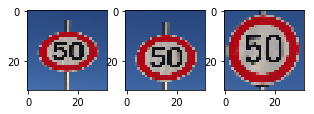

Number of examples at trainning set:1260


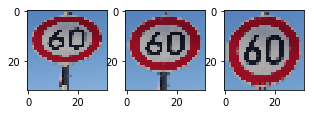

Number of examples at trainning set:480


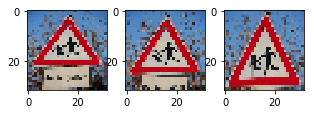

Number of examples at trainning set:1860


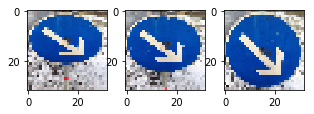

Number of examples at trainning set:690


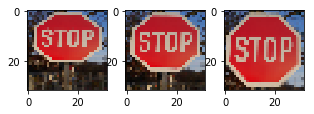

In [81]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2

#path for images downloaded from the web
PATH_ORIGINAL = 'german_signs/original/'
PATH_HAND_CROP = 'german_signs/crop/'

#get dataset statistics for images
y_hist = np.histogram(y_train, range(0, n_classes))

#image holders
web_images_original = []
web_images_crop = []
web_images_hand_crop = []

#labels
web_images_labels = [2,3,28,38,14]

i=0
#Get original and crop images
for f in os.listdir(PATH_ORIGINAL): 
    #open image 
    img = mpimg.imread(PATH_ORIGINAL + f)      
    
    #crop center to avoid distortion
    iy,ix,ic = img.shape
    startx = ix//2-(352//2)
    starty = iy//2-(352//2)    
    img_crop = img[0:starty+352,startx:startx+352]
    #resize
    img = cv2.resize(img,(32,32))
    img_crop = cv2.resize(img_crop,(32,32))
    #store
    web_images_original.append(img)
    web_images_crop.append(img_crop) 
    
    
#Get hand cropped images for accuracy comparison
for f in os.listdir(PATH_HAND_CROP): 
    #open image 
    img = mpimg.imread(PATH_HAND_CROP + f)     
    #resize
    img = cv2.resize(img,(32,32))     
    web_images_hand_crop.append(img)
     
#print images
print("   Oringal      Cropped     Hand Cropped")
for i in range(5):
    plt.figure(figsize=(5,5))    
    plt.subplot(3,3,1)
    plt.imshow(web_images_original[i]) 
    plt.subplot(3,3,2)
    plt.imshow(web_images_crop[i]) 
    plt.subplot(3,3,3)
    plt.imshow(web_images_hand_crop[i]) 
    print("Number of examples at trainning set:{}".format(y_hist[0][web_images_labels[i]]))
    plt.show()
    
web_images_original = np.array(web_images_original)
web_images_crop = np.array(web_images_crop)
web_images_hand_crop = np.array(web_images_hand_crop)




### Predict the Sign Type for Each Image

In [82]:
#Predict labels for the images collected from the web
#Pre-Processing functionas are part of the tensor pipeline (see Pre-process the Data Set above)

web_images_prediction_original = []
web_images_prediction_crop = []
web_images_prediction_hand_crop = []

x_web = tf.placeholder(tf.float32, (None, 32, 32, 3))
x_crop = tf.map_fn(lambda img: tf.image.resize_image_with_crop_or_pad(img, 32, 32), x_web) 

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    #x_web_images = sess.run(x_crop, feed_dict={x_web: web_images})
    
    #for img in x_web_images:
    #    plt.imshow(img)
    
    print("Prediction for original images from the web")
    for prediction in sess.run(logits, feed_dict={x: web_images_original, keep_prob:1}):
        web_images_prediction_original.append(np.argmax(prediction))
        print('Prediction is ', np.argmax(prediction))
        
    print()
    print("Prediction for croped images from the web")
    for prediction in sess.run(logits, feed_dict={x: web_images_crop, keep_prob:1}):
        web_images_prediction_crop.append(np.argmax(prediction))
        print('Prediction is ', np.argmax(prediction))
        
    print()
    print("Prediction for hand croped images from the web")
    for prediction in sess.run(logits, feed_dict={x: web_images_hand_crop, keep_prob:1}):
        web_images_prediction_hand_crop.append(np.argmax(prediction))
        print('Prediction is ', np.argmax(prediction))

Prediction for original images from the web
Prediction is  2
Prediction is  40
Prediction is  31
Prediction is  38
Prediction is  5

Prediction for croped images from the web
Prediction is  2
Prediction is  3
Prediction is  28
Prediction is  38
Prediction is  3

Prediction for hand croped images from the web
Prediction is  2
Prediction is  3
Prediction is  28
Prediction is  38
Prediction is  14


### Analyze Performance

In [78]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
print("Accuracy Evaluation for Web Images")
ok_original = 0
ok_crop = 0
ok_hand_crop = 0
for i in range(5):
    if web_images_prediction_original[i] == web_images_labels[i]:
        ok_original=ok_original+1
    if web_images_prediction_crop[i] == web_images_labels[i]:
        ok_crop=ok_crop+1
    if web_images_prediction_hand_crop[i] == web_images_labels[i]:
        ok_hand_crop=ok_hand_crop+1
        
print("Accuracy for the original images is {:.6f}".format(ok_original/float(5)))
print("Accuracy for the cropped images is {:.6f}".format(ok_crop/float(5)))
print("Accuracy for the hand cropped images is {:.6f}".format(ok_hand_crop/float(5)))


Accuracy Evaluation for Web Images
Accuracy for the original images is 0.400000
Accuracy for the cropped images is 0.800000
Accuracy for the hand cropped images is 1.000000


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [79]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 

top_k_op = tf.nn.top_k(logits, k=5)

top_prob = tf.nn.softmax(logits)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    print("Top 5 for orginal imagens")
    logs, probs = sess.run([top_k_op, top_prob], feed_dict={x: web_images_original, keep_prob:1})
    print(logs)
    print("Probabilities:")
    print(web_images_original.size)
    for j in range(5): 
        print("Image {}".format(j))
        print(probs[j][logs.indices[j]])
    
    print()
    print("Top 5 for cropped imagens")
    logs, probs = sess.run([top_k_op, top_prob], feed_dict={x: web_images_crop, keep_prob:1})
    print(logs),
    print("Probabilities:")
    for j in range(5): 
        print("Image {}".format(j))
        print(probs[j][logs.indices[j]])
    
    print()
    print("Top 5 for hand cropped imagens")
    logs, probs = sess.run([top_k_op, top_prob], feed_dict={x: web_images_hand_crop, keep_prob:1})
    print(logs)
    print("Probabilities:")
    for j in range(5): 
        print("Image {}".format(j))
        print(probs[j][logs.indices[j]])

Top 5 for orginal imagens
TopKV2(values=array([[  3.76126933,   1.97450793,   1.7979188 ,  -0.71677107,
         -1.76849639],
       [ -7.09511948,  -7.71542454, -10.0108242 , -10.78087044,
        -10.78159714],
       [-11.87063599, -14.648633  , -16.25683784, -16.27073097,
        -16.73569489],
       [  3.72774863, -10.07285881, -13.91492558, -15.06607628,
        -15.43828678],
       [ -7.25050974,  -7.73496103,  -7.82299757,  -8.62721539,
         -9.51918602]], dtype=float32), indices=array([[ 2,  7,  5,  1,  8],
       [40, 17,  2,  1, 37],
       [31, 23, 11, 28, 21],
       [38, 13, 34, 23, 12],
       [ 5,  2,  3,  7, 40]], dtype=int32))
Probabilities:
15360
Image 0
[ 0.75394344  0.12628685  0.10584406  0.00856152  0.00299083]
Image 1
[ 0.59096038  0.31780687  0.03200987  0.0148203   0.01480954]
Image 2
[ 0.90536141  0.05627989  0.01126987  0.01111437  0.00698158]
Image 3
[  9.99998927e-01   1.01501337e-06   2.17712710e-08   6.88565027e-09
   4.74565809e-09]
Image 4
[ 0.3

---

## Step 4: Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [47]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(name, image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    plt.suptitle('Layer ' + layer, fontsize=14, fontweight='bold') 
    for featuremap in range(featuremaps):
        plt.subplot(8,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
    plt.savefig('layers/' + name + '.png', dpi=100)

#Print All Layer images        
layers = ['conv1:0', 'relu1:0', 'conv2:0', 'relu2:0', 'pool1:0', 'conv3:0', 'relu3:0', 'conv4:0', 'relu4:0', 'pool2:0']
            
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))    
    for layer in layers:        
        activation = sess.graph.get_tensor_by_name(layer)
        #outputFeatureMap(layer, [web_images_hand_crop[0]], activation) 
        
print("Neural Network images saved at layer folder")

Neural Network images saved at layer folder


### Question 9

Discuss how you used the visual output of your trained network's feature maps to show that it had learned to look for interesting characteristics in traffic sign images


**Answer:**

The visual output of the network layers helped to:

1- to understand if the network is learning the image features. Checking the number of "activated neurons", or the number of black images, helped us to understand if the network was under or over fitting;

2- to see what the network is observing from the image, i.e. to show the network learned filters (kernels). 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 